In [1]:
from math import log as log
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
RANDOM_SEED = 42

# Вспомогательные функции

In [3]:
def outliers(df, column):
    q25 = df[column].quantile(0.25)
    q75 = df[column].quantile(0.75)
    IQR = q75 - q25
    print('Количество выбросов за левой границей: ',
          len(df.loc[df[column] < q25-(IQR*1.5)][column]))
    print('Количество выбросов за правой границей: ',
          len(df.loc[df[column] > q75+(IQR*1.5)][column]))

# Импорт данных

In [4]:
df_train = pd.read_csv(r'B:/SKILL_FACTORY/train.csv')
df_test = pd.read_csv(r'B:/SKILL_FACTORY/test.csv')
df = df_train.append(df_test, sort=False).reset_index(drop=True)

Описания полей датасета:

client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

In [5]:
print('Размерность тренировочного датасета: ', df_train.shape)
print('Размерность тестового датасета: ', df_test.shape)

Размерность тренировочного датасета:  (73799, 19)
Размерность тестового датасета:  (36349, 18)


In [6]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0


# Предварительный анализ данных

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [8]:
for i in df.columns:
    print(i, df[i].nunique())

client_id 110148
app_date 120
education 5
sex 2
age 52
car 2
car_type 2
decline_app_cnt 24
good_work 2
score_bki 102618
bki_request_cnt 40
region_rating 7
home_address 3
work_address 3
income 1207
sna 4
first_time 4
foreign_passport 2
default 2


После соединения 2х датасето в (train, test) в один, в итоге выходит 110148 строк.

Всего в датасете имеется 19 признаков. 1 - временной ряд, 6 - бинарных, 6 - категориальных, 6 - числовых.

In [9]:
# временной ряд (1)
time_cols = ['app_date']
# бинарные переменные (default не включаем в список) (6-1 = 5)
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
# категориальные переменные  (6)
cat_cols = ['education', 'region_rating',
            'home_address', 'work_address', 'sna', 'first_time']
# числовые переменные, client_id исключили из списка (5)
num_cols = ['age', 'decline_app_cnt', 'score_bki',
            'bki_request_cnt', 'income', 'days']

In [10]:
df.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
dtype: int64

В датасете примутствуют пропуски только в признаке "education" в размере 478 шт, это 0.0043 от общего количесва строк.

# Анализ признаков

### 1) age

In [11]:
df['age'].describe()

count    110148.000000
mean         39.249410
std          11.518063
min          21.000000
25%          30.000000
50%          37.000000
75%          48.000000
max          72.000000
Name: age, dtype: float64

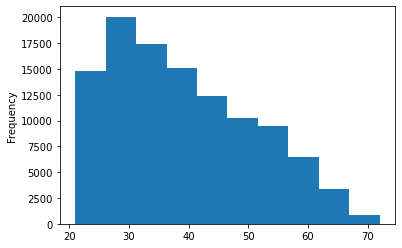

In [12]:
df['age'].plot.hist()

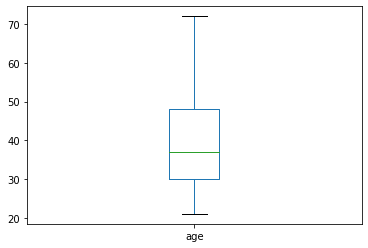

In [13]:
df['age'].plot.box()

In [14]:
outliers(df, 'age')

Количество выбросов за левой границей:  0
Количество выбросов за правой границей:  0


Распределение признака смещённое право, выбросов нет, приведём его к логнормальному с помощью логарифма

In [15]:
df['age'] = np.log(df['age'] + 1)

### 2) decline_app_cnt 

In [16]:
df['decline_app_cnt'].describe()

count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64

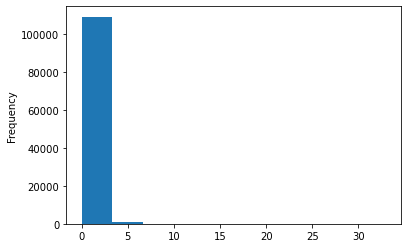

In [17]:
df['decline_app_cnt'].plot.hist()

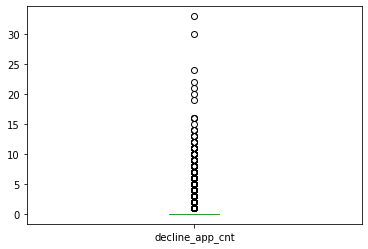

In [18]:
df['decline_app_cnt'].plot.box()

In [19]:
outliers(df, 'decline_app_cnt')

Количество выбросов за левой границей:  0
Количество выбросов за правой границей:  18677


Данный признак имеет значительную часть выбросов, сделаем распределение этого признака логнормальным. Пока оставим прихнак как он есть

In [20]:
df['decline_app_cnt'] = np.log(df['decline_app_cnt']+1)

### 3) score_bki

In [21]:
df['score_bki'].describe()

count    110148.000000
mean         -1.904535
std           0.499397
min          -3.624586
25%          -2.260434
50%          -1.920823
75%          -1.567888
max           0.199773
Name: score_bki, dtype: float64

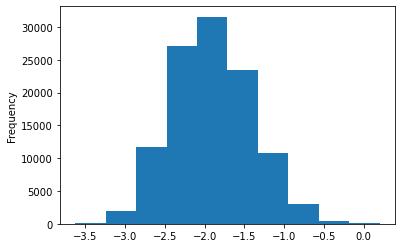

In [22]:
df['score_bki'].plot.hist()

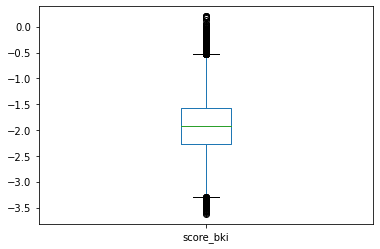

In [23]:
df['score_bki'].plot.box()

In [24]:
outliers(df, 'score_bki')

Количество выбросов за левой границей:  82
Количество выбросов за правой границей:  436


Данные признак имеет нормальное распределение, дополнительных действий производить не надо. Имеются выбросыю, но их количество мало. Пока оставим так как есть.

### 4) bki_request_cnt

In [25]:
df['bki_request_cnt'].describe()

count    110148.000000
mean          2.005002
std           2.266926
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          53.000000
Name: bki_request_cnt, dtype: float64

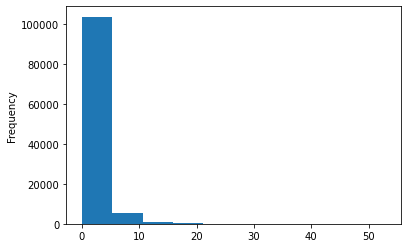

In [26]:
df['bki_request_cnt'].plot.hist()

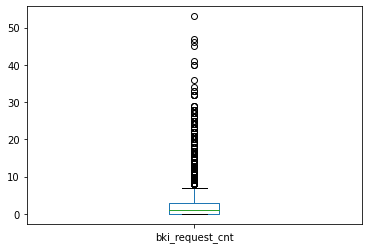

In [27]:
df['bki_request_cnt'].plot.box()

In [28]:
outliers(df, 'bki_request_cnt')

Количество выбросов за левой границей:  0
Количество выбросов за правой границей:  2636


In [29]:
df['bki_request_cnt'] = np.log(df['bki_request_cnt'] + 1)

Данный признак имеет логнормальное распредение, так как взяли логарифм, выбросов не так много. Пока оставим так как есть.

### 5) income

In [30]:
df['income'].describe()

count     110148.000000
mean       41012.648537
std        45399.735051
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64

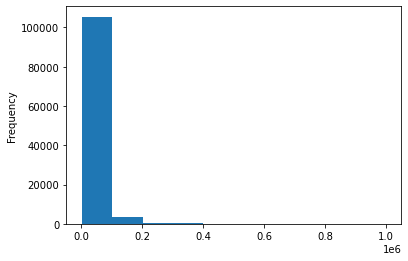

In [31]:
df['income'].plot.hist()

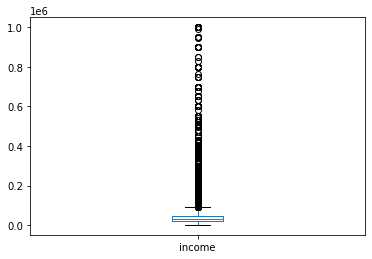

In [32]:
df['income'].plot.box()

In [33]:
outliers(df, 'income')

Количество выбросов за левой границей:  0
Количество выбросов за правой границей:  7000


In [34]:
df['income'] = np.log(df['income']+1)

Данный признак имеет логнормальное распредение, так как взяли логарифм, существенное количество выбросов с правой стороны. Пока оставим так как есть.

### 6) education

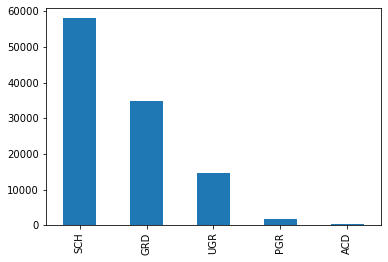

In [35]:
df['education'].value_counts().plot.bar()

В данном признаке имеются пропуски, заполним их самым популярным значением.

In [36]:
df['education'] = df['education'].fillna('SCH')

### 7) region_rating

In [37]:
df['region_rating'].describe()

count    110148.000000
mean         56.751189
std          13.065923
min          20.000000
25%          50.000000
50%          50.000000
75%          60.000000
max          80.000000
Name: region_rating, dtype: float64

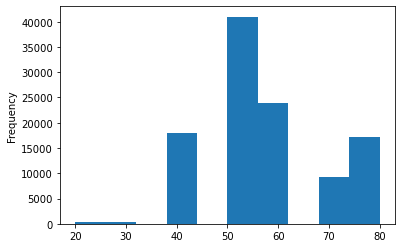

In [38]:
df['region_rating'].plot.hist()

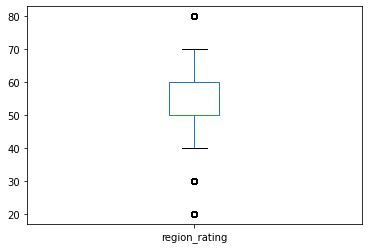

In [39]:
df['region_rating'].plot.box()

In [40]:
outliers(df, 'region_rating')

Количество выбросов за левой границей:  747
Количество выбросов за правой границей:  17170


В данном признаке распределение нормальное. Имеется очень большое количество выбросов. Пока оставим так как есть.

### 8) sna

In [41]:
df['sna'].describe()

count    110148.000000
mean          1.731588
std           1.122652
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           4.000000
Name: sna, dtype: float64

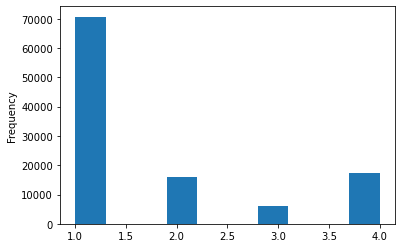

In [42]:
df['sna'].plot.hist()

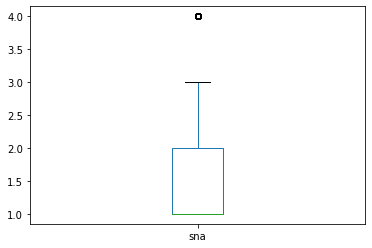

In [43]:
df['sna'].plot.box()

In [44]:
outliers(df, 'sna')

Количество выбросов за левой границей:  0
Количество выбросов за правой границей:  17481


В данном признаке распределение смещённое вправо. Выбросов нет.

### 9) first_time

In [45]:
df['first_time'].describe()

count    110148.000000
mean          2.765570
std           1.010151
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           4.000000
Name: first_time, dtype: float64

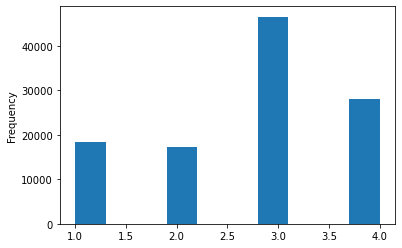

In [46]:
df['first_time'].plot.hist()

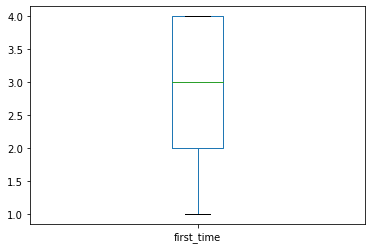

In [47]:
df['first_time'].plot.box()

In [48]:
outliers(df, 'first_time')

Количество выбросов за левой границей:  0
Количество выбросов за правой границей:  0


В данном признаке смщённгое влево распределение. Выбросов нет.

### 10) app_date

In [49]:
df['app_date'] = pd.to_datetime(df['app_date'], format='%d%b%Y')

In [50]:
print(df['app_date'].min(), '||', df['app_date'].max())
start = df['app_date'].min()
end = df['app_date'].max()

2014-01-01 00:00:00 || 2014-04-30 00:00:00


Создадим признак количества дней с минимальной даты

In [51]:
df['days'] = (df['app_date'] - start).dt.days

In [52]:
df

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,days
0,25905,2014-02-01,SCH,M,4.143135,Y,Y,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,N,0.0,31
1,63161,2014-03-12,SCH,F,4.094345,N,N,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,N,0.0,70
2,25887,2014-02-01,SCH,M,3.258097,Y,N,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,Y,0.0,31
3,16222,2014-01-23,SCH,F,3.988984,N,N,0.000000,0,-2.057471,1.098612,50,2,3,9.210440,1,3,N,0.0,22
4,101655,2014-04-18,GRD,M,3.891820,N,N,0.000000,1,-1.244723,0.693147,60,2,3,10.308986,1,4,Y,0.0,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,2014-03-31,SCH,F,3.637586,N,N,0.693147,0,-1.744976,1.386294,50,2,3,9.615872,4,1,N,NaN,89
110144,106254,2014-04-25,GRD,F,4.174387,Y,Y,0.000000,0,-2.293781,1.386294,60,1,2,12.206078,1,4,N,NaN,114
110145,81852,2014-03-30,GRD,M,3.465736,N,N,1.098612,0,-0.940752,0.693147,50,1,2,11.002117,4,2,N,NaN,88
110146,1971,2014-01-07,UGR,F,3.332205,N,N,0.693147,0,-1.242392,1.098612,80,2,3,10.308986,1,1,N,NaN,6


# Оценка корреляций

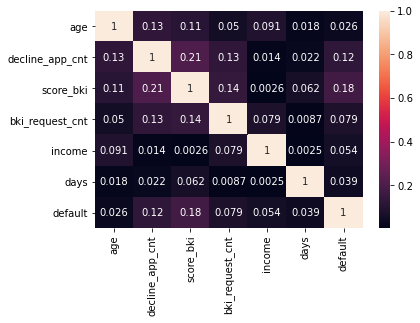

In [53]:
sns.heatmap(df[num_cols+['default']].corr().abs(), annot=True)

Исходя из матрицы корреляций, признаки между собой не скоррелированы, значит, что выбрасывать ничего не надо.

### Проверка на значимость числовых переменных

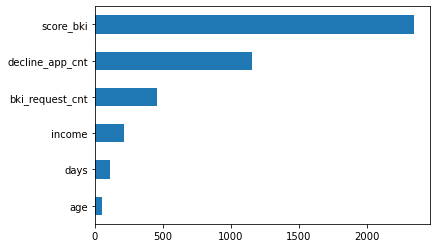

In [54]:
imp_num = pd.Series(f_classif(df[num_cols][:df_train.shape[0]],
                              df.loc[df['default'].isna() == False]['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Исходя из F-test score_bki - самый значимый показатель, на втором месте declain_app_cnt, сымым последним является age.

### Проверка на значимость категориальных и бинарных переменных.

In [55]:
label_encoder = LabelEncoder()
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

fake_df = df.loc[df['default'].isna() == False]
label_encoder = LabelEncoder()
fake_df['education'] = label_encoder.fit_transform(fake_df['education'])

B:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


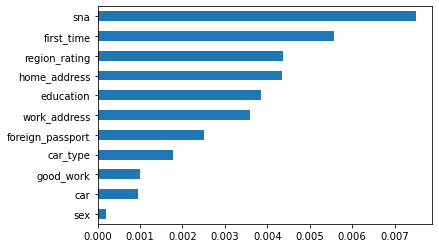

In [56]:
imp_num = pd.Series(mutual_info_classif(fake_df[cat_cols+bin_cols][:df_train.shape[0]],
                                        fake_df.loc[df['default'].isna() == False]['default'],
                                        discrete_features=True),
                    index=cat_cols+bin_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Исходя из Mutual information теста, "sna" является самым знгачимым признаком, на втором месте "first_time", на третьем "region_rating", и в самом конце "sex" 

# Подготовка данных к машинному обучению и построение модели

In [57]:
df = pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)

In [58]:
df.drop(['app_date', 'client_id'], axis=1, inplace=True)

In [59]:
df_train = df.loc[df['default'].isna() == False]
df_test = df.loc[df['default'].isna() == True]
Y = df_train['default'].values
X = df_train.drop(['default'], axis=1).values

Разбиваем данные. 20 процентов пойдёт на валидацию.

In [60]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_SEED)

### Обучаем модель логистической регрессии

In [61]:
model = LogisticRegression(random_state=RANDOM_SEED).fit(X_train, Y_train)
Y_pred_proba = model.predict_proba(X_test)[:, 1]
Y_pred = model.predict(X_test)

B:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Качественные метрики

In [62]:
print(f'accuracy: {round(accuracy_score(Y_test,Y_pred),4)} \
    \nprecision: {round(precision_score(Y_test,Y_pred),4)} \
    \nrecall: {round(recall_score(Y_test, Y_pred),4)} \
    \nf1: {round(f1_score(Y_test, Y_pred),4)} \
    \nroc_auc: {round(roc_auc_score(Y_test, Y_pred_proba),4)}')

accuracy: 0.875     
precision: 0.4043     
recall: 0.0208     
f1: 0.0396     
roc_auc: 0.7452


#### Матрица ошибок

In [63]:
confusion_matrix(Y_test,Y_pred)

array([[12877,    56],
       [ 1789,    38]], dtype=int64)

TN = 12877; FP = 56

FN = 1789; TP = 38

#### ROC кривая

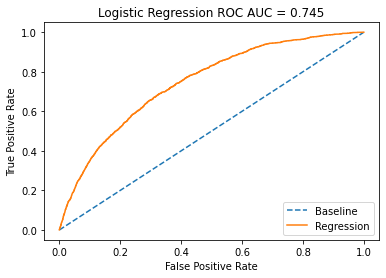

In [64]:
fpr, tpr, threshold = roc_curve(Y_test, Y_pred_proba)
roc_auc = roc_auc_score(Y_test, Y_pred_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

Вывод: Данная модель является не той, которую можно было бы использовать. Модель не предсказала клиентов с характеристикой "default". Таким образом, появляется очень большая ошибка второго рода. Также об этой плохой ситуации говорит f1_score.

### Запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3

In [65]:
model = LogisticRegression(random_state=RANDOM_SEED)

iterations = 50
stop = 0.001

hyperparameters = [
    {'penalty': ['l1'],
     'solver': ['liblinear', 'lbfgs'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr'],
     'max_iter':[iterations],
     'tol':[stop]},
    {'penalty': ['l2'],
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr'],
     'max_iter':[iterations],
     'tol':[stop]},
    {'penalty': ['none'],
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
     'class_weight':['none', 'balanced'],
     'multi_class': ['auto', 'ovr'],
     'max_iter':[iterations],
     'tol':[stop]},
]

gridsearch = GridSearchCV(model, hyperparameters,
                          scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, Y_train)
model = gridsearch.best_estimator_

# Выведем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
    print(f'{param_name}: {best_parameters[param_name]}')

print('\n\n')

Y_pred = model.predict(X_test)
print(f'accuracy: {round(accuracy_score(Y_test,Y_pred),4)} \
    \nprecision: {round(precision_score(Y_test,Y_pred),4)} \
    \nrecall: {round(recall_score(Y_test, Y_pred),4)} \
    \nf1: {round(f1_score(Y_test, Y_pred),4)}')

C: 1.0
class_weight: balanced
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 50
multi_class: auto
n_jobs: None
penalty: l2
random_state: 42
solver: sag
tol: 0.001
verbose: 0
warm_start: False



accuracy: 0.6687     
precision: 0.2256     
recall: 0.6891     
f1: 0.3399


B:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Подобрав оптимальные параметры, и применив их к модели, можно увидеть, что такая метрика как f1_score выросла 10 раз. А это значит,что модель стала работать куда эффективнее.

Строим модель с оптимальными параметрами

In [66]:
model = LogisticRegression(random_state=RANDOM_SEED,
                           C=1,
                           class_weight='balanced',
                           dual=False,
                           fit_intercept=True,
                           intercept_scaling=1,
                           l1_ratio=None,
                           multi_class='auto',
                           n_jobs=None,
                           penalty='l2',
                           solver='sag',
                           verbose=0,
                           warm_start=False).fit(X_train, Y_train)

Y_pred_proba = model.predict_proba(X_test)[:, 1]
Y_pred = model.predict(X_test)

B:\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


### Оценка качества модели на оптимальных параметрах

#### Качественные метрики

In [67]:
print(f'accuracy: {round(accuracy_score(Y_test,Y_pred),4)} \
    \nprecision: {round(precision_score(Y_test,Y_pred),4)} \
    \nrecall: {round(recall_score(Y_test, Y_pred),4)} \
    \nf1: {round(f1_score(Y_test, Y_pred),4)} \
    \nroc_auc: {round(roc_auc_score(Y_test, Y_pred_proba),4)}')

accuracy: 0.6705     
precision: 0.2263     
recall: 0.6869     
f1: 0.3404     
roc_auc: 0.7442


#### Матрица ошибок

In [68]:
confusion_matrix(Y_test,Y_pred)

array([[8642, 4291],
       [ 572, 1255]], dtype=int64)

TN = 8642; FP = 4291

FN = 572; TP = 1255

#### ROC кривая

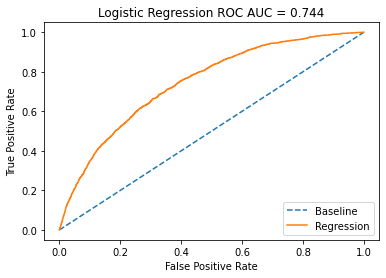

In [69]:
fpr, tpr, threshold = roc_curve(Y_test, Y_pred_proba)
roc_auc = roc_auc_score(Y_test, Y_pred_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label='Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

Вывод: По сравнению с предыдущей моделью, эта показывает себя куда лучше (это можно увидеть по матрице ошибок). Также, доказательством этого является повышение в 10 раз f1_score.